In [1]:
import numpy as np
import scipy.io as sio
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filepath = "/Users/xizheng/Documents/florin/respiration/K1/K1_20191226_r0_traces.mat"
Traces = sio.loadmat(filepath)['Traces']

In [3]:
def process_resp(resp):
    windowsize = 15
    resp = resp - np.median(resp)
    resp = -resp
    resp = np.convolve(resp, np.ones(windowsize), 'same') / windowsize
    resp_pks_2, _ = find_peaks(-resp, prominence=0.3, height=0.2, distance=10)
    
    return resp, resp_pks_2

In [8]:
resp_trial_interval_first = []
resp_trial_interval_after = []
move_trial_interval_first = []
move_trial_interval_after = []
lick_interval_first = []
lick_interval_after = []

for idx in range(Traces[0,0]['Trial'].shape[1]):
# for idx in range(2):
    
#     print("start analyzing", idx)
    # get data
    resp = Traces[0,0]['Sniffs'][0,idx].flatten()
    trial_on = Traces[0,0]['Trial'][0,idx].flatten()!=0
    if len(resp) == 0:
        print("skipping trial", idx)
        continue
    
    # select region to study
#     trial_off_idx = np.where(trial_on!=0)[0][-1]+1
    trial_off_idx = len(trial_on)
    trial_on = trial_on[:trial_off_idx]
    
    # resp
    resp, resp_pks_2 = process_resp(resp[:trial_off_idx])
    
    # lever
    lever = Traces[0,0]['Lever'][0,idx].flatten()
    lever = savgol_filter(lever, 25, 4)
    lever = lever[:trial_off_idx]
    
    pks1, _ = find_peaks(lever, prominence=0.01, distance=5)
    pks2, _ = find_peaks(-lever, prominence=0.01, distance=5)
    peaks = np.concatenate((pks1, pks2))
    peaks = np.sort(peaks)
    
    movement = np.zeros(len(peaks)-1)
    for i in range(len(peaks)-1):
        movement[i] = abs(lever[peaks[i+1]] - lever[peaks[i]])
    movement_signal = np.zeros(len(lever))
    movement_signal[peaks[:-1]] = movement
    
    # lick
    licks = Traces[0,0]['Licks'][0,idx].flatten()
    licks_idx = np.where(licks!=0)[0]
    
    for start_idx in range(len(resp_pks_2)-1):
        if trial_on[resp_pks_2[start_idx]] != 0:
            if resp_pks_2[start_idx] <= 1000:
                resp_trial_interval_first.append(resp_pks_2[start_idx+1] - resp_pks_2[start_idx])
            else:
                resp_trial_interval_after.append(resp_pks_2[start_idx+1] - resp_pks_2[start_idx])
                
    for start_idx in range(len(peaks)-1):
        if trial_on[peaks[start_idx]] != 0 and movement_signal[peaks[start_idx]]> 1:
            if peaks[start_idx] <= 1000:
                move_trial_interval_first.append(peaks[start_idx+1] - peaks[start_idx])
            else:
                move_trial_interval_after.append(peaks[start_idx+1] - peaks[start_idx])
                
    for start_idx in range(len(licks_idx)-1):
        if trial_on[licks_idx[start_idx]] != 0:
            if licks_idx[start_idx] <= 1000:
                lick_interval_first.append(licks_idx[start_idx+1] - licks_idx[start_idx])
            else:
                lick_interval_after.append(licks_idx[start_idx+1] - licks_idx[start_idx])

skipping trial 0
skipping trial 56


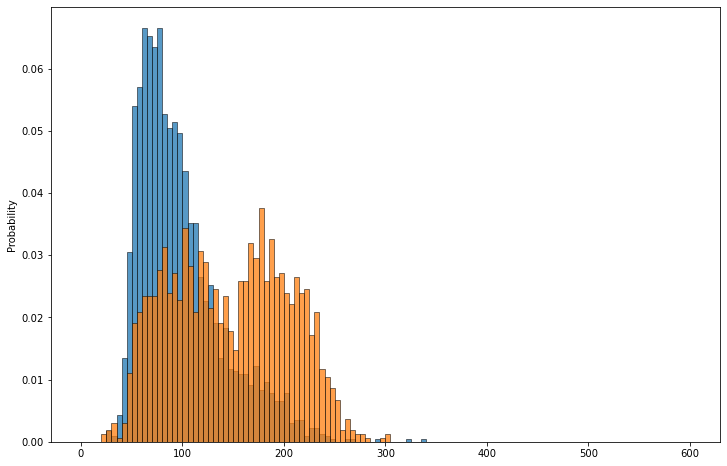

In [9]:
plt.figure(figsize=(12,8))
sns.histplot(resp_trial_interval_first, binwidth=5, stat="probability",binrange=(0,600), color='#1f77b4')
sns.histplot(resp_trial_interval_after, binwidth=5, stat="probability", binrange=(0,600), color='#ff7f0e')
plt.show()


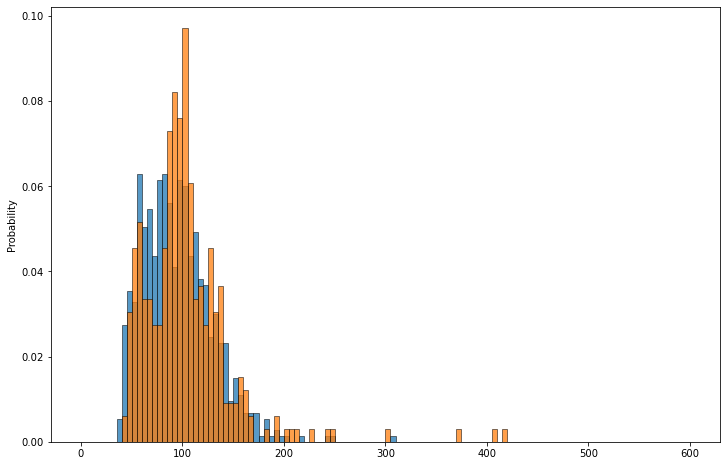

In [10]:
plt.figure(figsize=(12,8))
sns.histplot(move_trial_interval_first, binwidth=5, stat="probability",binrange=(0,600), color='#1f77b4')
sns.histplot(move_trial_interval_after, binwidth=5, stat="probability", binrange=(0,600), color='#ff7f0e')
plt.show()


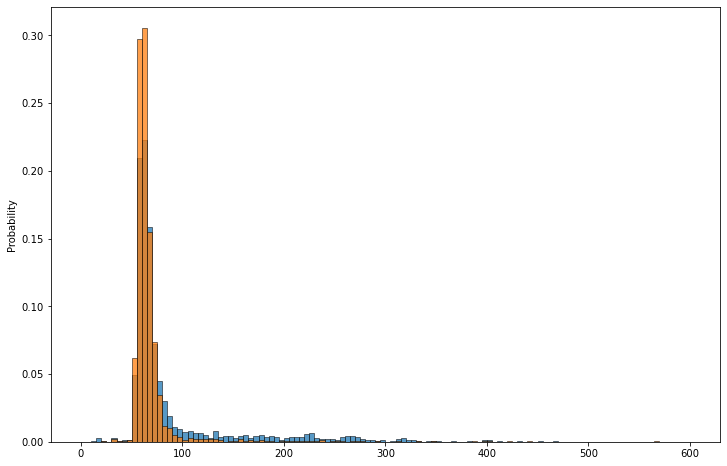

In [11]:
plt.figure(figsize=(12,8))
sns.histplot(lick_interval_first, binwidth=5, stat="probability",binrange=(0,600), color='#1f77b4')
sns.histplot(lick_interval_after, binwidth=5, stat="probability", binrange=(0,600), color='#ff7f0e')
plt.show()
